In [3]:
import os
import torch,glob
import torch.nn as nn
import matplotlib.pyplot as plt

from PIL import Image
from torch import optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [4]:
class ChessCoin(Dataset):
    def __init__(self, main_folder_path, transform= None):
        self.main_folder_path = main_folder_path
        self.transform = transform
        self.x , self.y = self.folder_reader()

    def folder_reader(self):
        sub_folders = [folder_name for folder_name in os.listdir(self.main_folder_path) if os.path.isdir(os.path.join(self.main_folder_path,folder_name))]
        x =[os.path.join(self.main_folder_path,sub_folder_name,file_name) for sub_folder_name in sub_folders if sub_folder_name in ("Ak", "Ala_Idris") for file_name in os.listdir(os.path.join(self.main_folder_path,sub_folder_name))]
        y = [1 if "Ak" in file_name.split('/')[-1] else 0 for file_name in x]
        return x, torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.x)

    def __getitem__(self,idx):
        image = Image.open(self.x[idx])
        if self.transform:
            image = self.transform(image)
        label = self.y[idx]
        return image, label

transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

dataset = ChessCoin(main_folder_path= '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset', transform= transform)
dataloader = DataLoader(dataset, batch_size= 2,num_workers= 1, shuffle= True)

In [5]:
input_shape = 3136
output_shape = 1

class Net(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(Net,self).__init__()
        self.l1 = nn.Linear(input_shape, input_shape * 2)
        self.l2 = nn.Linear(input_shape * 2, input_shape * 2)
        self.l3 = nn.Linear(input_shape * 2, output_shape)

    def forward(self,x):
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        x = torch.sigmoid(self.l3(x))
        return x

model = Net(input_shape= input_shape, output_shape= output_shape)
model

Net(
  (l1): Linear(in_features=3136, out_features=6272, bias=True)
  (l2): Linear(in_features=6272, out_features=6272, bias=True)
  (l3): Linear(in_features=6272, out_features=1, bias=True)
)

In [ ]:
epochs = 10
loss_fn = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.02)

for epoch in range(epochs):
    for feature, label in dataloader:
        optimizer.zero_grad()
        y_hat = model(feature)
        error = loss_fn(y_hat, label.unsqueeze(-1).float())
        error.backward()
        optimizer.step()


    print(f"Epoch: {epoch + 1}/{epochs} Loss: {error.item():.4f}")

Epoch: 1/10 Loss: 0.7703
Epoch: 2/10 Loss: 0.6955
Epoch: 3/10 Loss: 0.1018
Epoch: 4/10 Loss: 0.5989
Epoch: 5/10 Loss: 0.1481
Epoch: 6/10 Loss: 0.2406
Epoch: 7/10 Loss: 0.9735
Epoch: 8/10 Loss: 0.3457
Epoch: 9/10 Loss: 0.4277


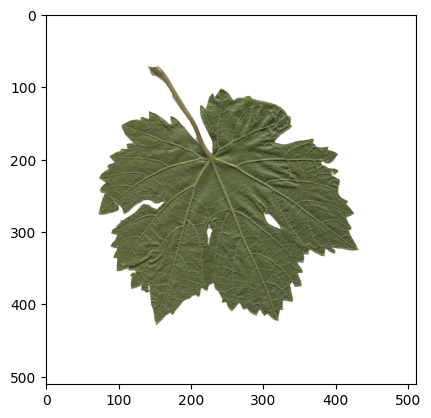

Prediction :  Ala_Idris


In [14]:
with torch.no_grad():
    img = '/kaggle/input/grapevine-leaves-image-dataset/Grapevine_Leaves_Image_Dataset/Buzgulu/Buzgulu (10).png'
    img_pil = Image.open(img)
    plt.imshow(img_pil)
    plt.show()
    img_pil = transform(img_pil)
    prediction = "Ak" if model(img_pil).item() > 0.5 else "Ala_Idris"
    print("Prediction : ", prediction)